# Introduction to GAN

In this tutorial, we are going to be following the excellent video lecture by Nicholas Renotte called Build a Generative Adversarial Neural Network with Tensorflow and Python | Deep Learning Projects which can be found at https://www.youtube.com/watch?v=AALBGpLbj6Q&t=73s.

Before we get started, we need to understand GAN. A GAN comprises of a Generator and a Discriminator.

Think of the Generator as an artist who wants to paint pictures but has no real-world experience (so he or she doesn't know what a car or cat looks like for example). As a result, this artist starts with a blank canvas and tries to turn it into an image that looks real. Of course, initially the generator is not very good, and the paintings look weird and random.

Next, there is the discriminator or the art critic. It looks at an image and tries to determine if it is a real image (from real-world data) or a fake one (created by the Generator). It looks at an image and gives it a high score if the image is real or a low score if it is fake.

Finally, the goal of the generator is to fool the discriminator into believing that the fake images are real. The goal of the discriminator is to catch the fake images and distinguish them from the real ones.

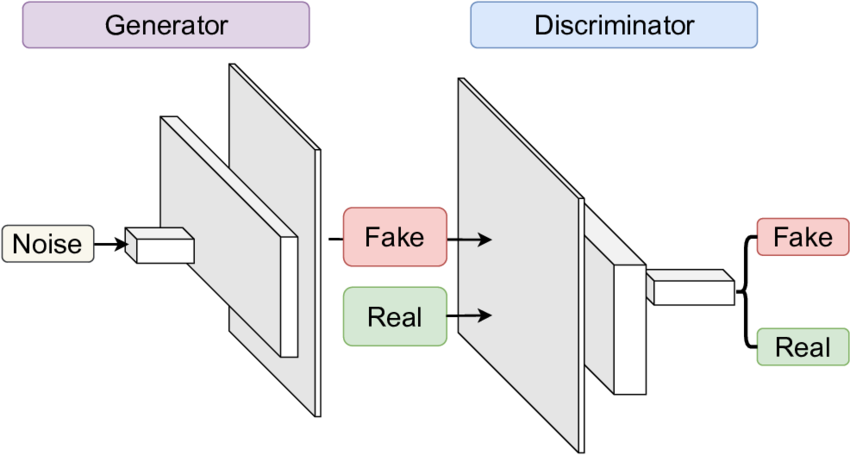

Credit: https://www.researchgate.net/figure/Generator-and-discriminator-of-the-GAN_fig2_341965995

# Install Dependencies

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

We don't want tensorflow to use/preallocate all of our GPU at the start. So, we can enabling memory growth which means that TensorFlow will only allocate as much GPU memory as needed for the runtime, and it will dynamically grow the memory usage as required, rather than pre-allocating all of it at the start.

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
#download the fashion mnist dataset
ds = tfds.load("fashion_mnist", split="train")

In [ ]:
#shows the keys in this dataset: (image, label)
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# Visualize and Build the Dataset

In [ ]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

In [ ]:
#It is actually stored with 1 channel dimension
(dataiterator.next()["image"]).shape

(28, 28, 1)

In [ ]:
#Hence we can squeeze it to remove the extra dimension
np.squeeze(dataiterator.next()["image"]).shape

(28, 28)

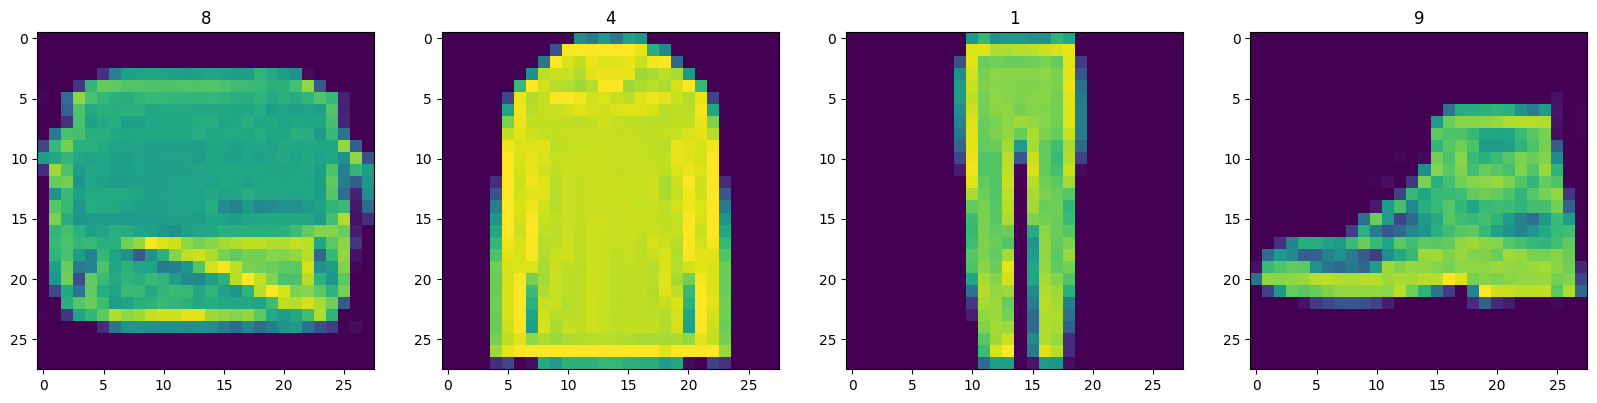

In [ ]:
# we want to draw 4 images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch["image"]))
  ax[idx].title.set_text(batch["label"])

In [ ]:
# scale image between [0, 1] so that the neural network can train it better
def scale_images(data):
  image = data["image"]
  return image / 255

In [ ]:
ds = tfds.load("fashion_mnist", split="train")

# Scale the images
ds = ds.map(scale_images)

# Cache the dataset so that the dataset is stored in memory after it's loaded
ds = ds.cache()

# Shuffle the dataset so that we get a randomized set of images
# Note: 60000 is the size of the dataset
ds = ds.shuffle(60000)

# Setting batch size (128 images per batch) so that we feed the images to our
# model in manageable chuncks instead of 1 image at a time
ds = ds.batch(128)

# Prefetches 64 batches of data at a time while the model is training so that
# the next batch of images are ready when the model needs to use them
ds = ds.prefetch(64)

In [ ]:
# 128 images per batch with a size of (28, 28, 1)
# the last 1 is because it is a gray-scaled image
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Building the Neural Network

In [ ]:
# Sequential API just performs all the operations in a "sequence" (one input, one output)
from tensorflow.keras.models import Sequential

# the layers for the neural network
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

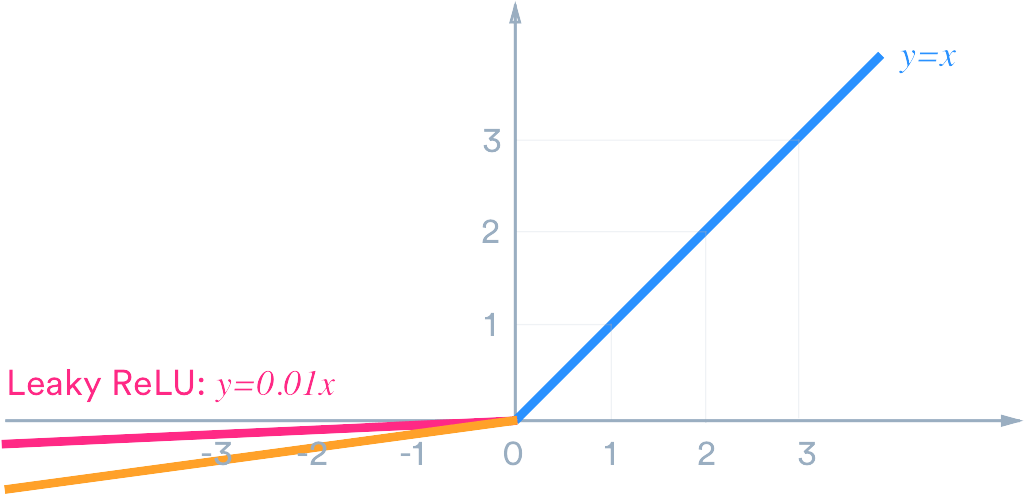

(Credit: https://himanshuxd.medium.com/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e)

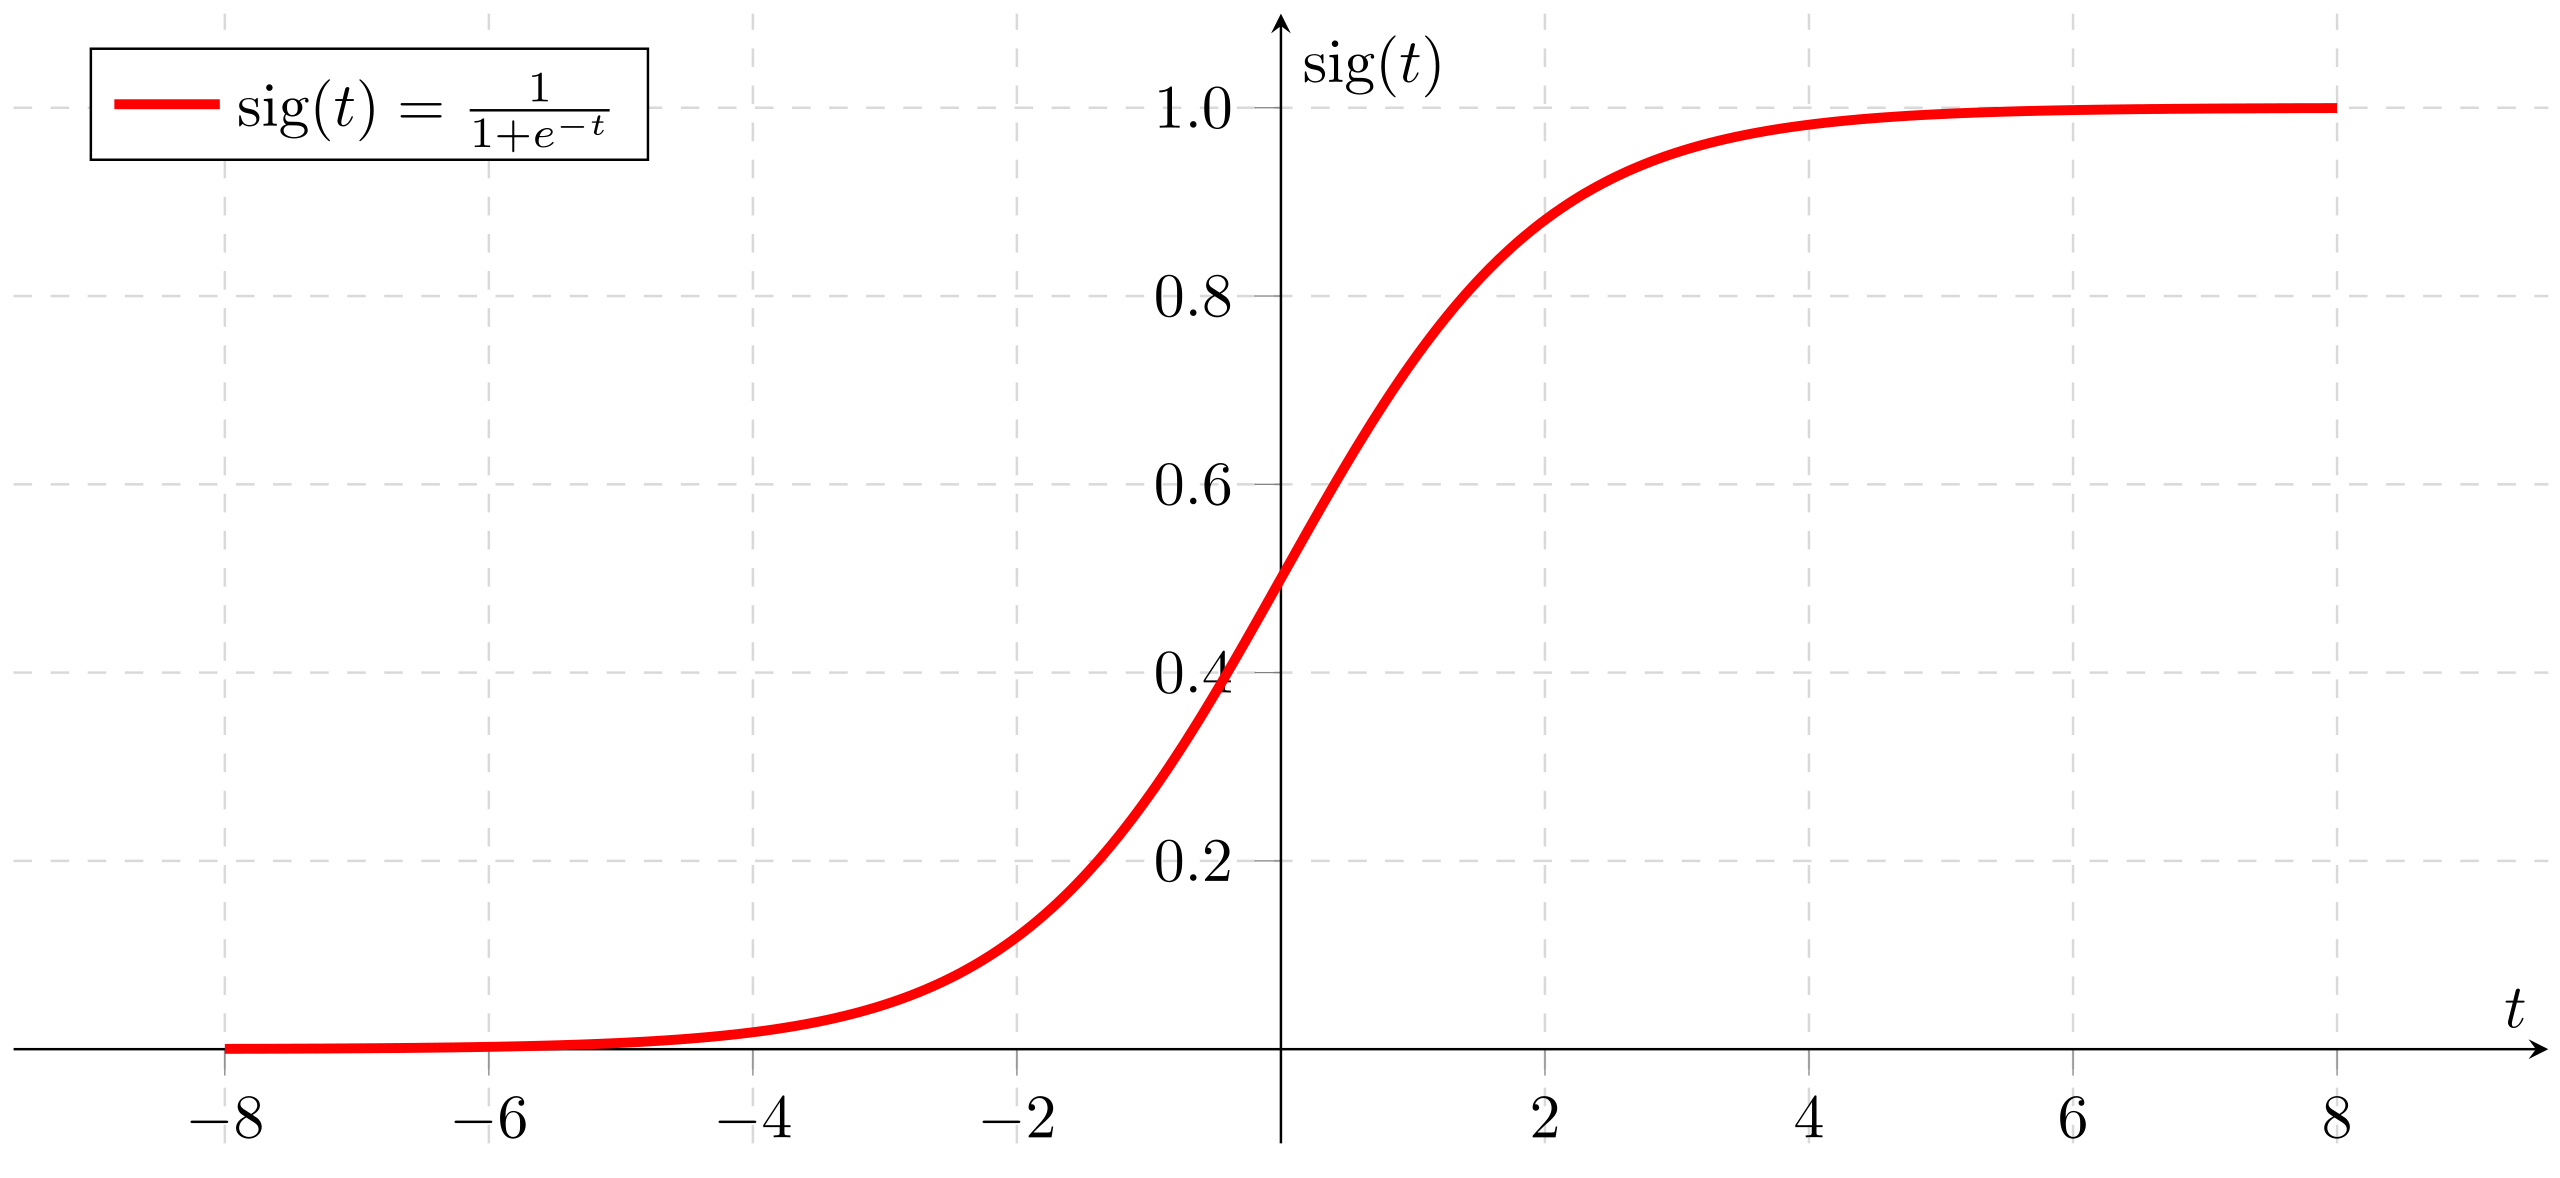

(Credit: https://cloud2data.com/activation-function-sigmoid/)

# Build the Generator

In [ ]:
def build_generator():
  model = Sequential()

  """
  Takes a random value and reshapes it to 7x7x128
  This is just the starting of the generated image
  The use of LeakyReLU ensures non-linearity and helps prevent dead neurons.
  """
  # using 128 random values and the GAN would generate random images
  model.add(Input((128, )))
  # start out with an image of 7 by 7 by 128 channels
  model.add(Dense(7*7*128))
  # activation function
  model.add(LeakyReLU(0.2))
  # reshape it to an image of 7 by 7 by 128 channels
  model.add(Reshape((7, 7, 128)))

  """
  Upsampling block 1: gives us an image of size 14 x 14 x 128
  """
  # Upsampling basically "doubles" the size of the output of the previous block
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding="same"))
  model.add(LeakyReLU(0.2))

  """
  Upsampling block 2: gives us an image of size 28 x 28 x 128
  """
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding="same"))
  model.add(LeakyReLU(0.2))

  """
  block 1: Another convolutional block to further refine the image.
  """
  model.add(Conv2D(128, 4, padding="same"))
  model.add(LeakyReLU(0.2))

  """
  block 2: Another convolutional block to further refine the image.
  """
  model.add(Conv2D(128, 4, padding="same"))
  model.add(LeakyReLU(0.2))

  """
  block 3: Final convolutional block to reduce the feature map to a single
  channel (grayscale image).
  This block uses a 1x1 kernel with 'sigmoid' activation to produce an output
  image of shape (28, 28, 1).
  The sigmoid function outputs values between [0, 1].
  """
  model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))

  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To generate an image

# generate 4 random images with random input (128, 1)
img = generator.predict(np.random.randn(4, 128, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


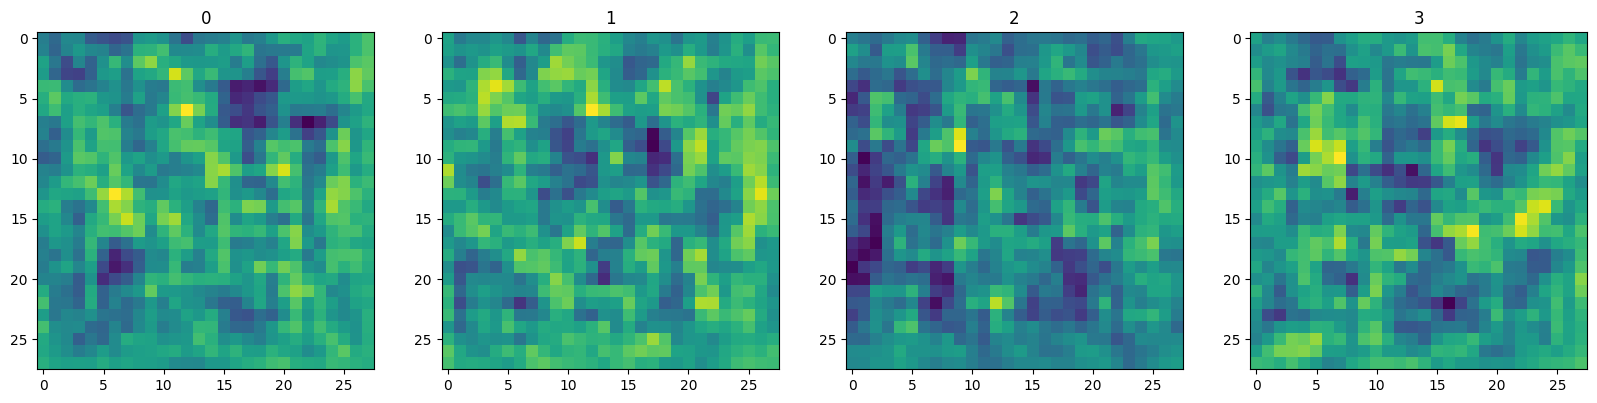

In [ ]:
# we want to draw 4 images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, image in enumerate(img):
  ax[idx].imshow(np.squeeze(image))
  ax[idx].title.set_text(idx)

# Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  """
  block 1: Convolutional block to extract features from the input image.
  """
  model.add(Input((28, 28, 1)))
  model.add(Conv2D(32, 5))
  model.add(LeakyReLU(0.2))

  # Dropout makes it harder for our model to learn
  model.add(Dropout(0.4))

  """
  block 2: Second Convolutional block
  """
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  """
  block 3: Third Convolutional block
  """
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  """
  block 4: Fourth Convolutional block
  """
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  """
  """
  model.add(Flatten())
  model.add(Dropout(0.4))
  # 1 is a false image and 0 is a true image (we will define this later)
  model.add(Dense(1, activation="sigmoid"))

  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_52 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_53 (LeakyReLU)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# The discriminator is not really that good right now (as we haven't trained it yet)
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


array([[0.49814984],
       [0.49831957],
       [0.49819148],
       [0.49833614]], dtype=float32)

# Custom Training Loop

This trains the generator and discriminator which is very difficult. We need to be able to find a balance between the generator and the discriminator learning so that the discriminator is not able to quickly learn that the generator images are fake.

We have already done this by using Dropout in the discriminator model so that this learning is kind of slowed down.

It also takes a lot of time to train a GAN model.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

Setup Losses and Optimizers

In [ ]:
# We want the discriminator to learn slower than the generator
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Wait a minute. We are using a BinaryCrossentropy even though our generator is producing an image.

However, what we are actually going to do is that we are going to see if the image generated by the generator is able to trick the discriminator or not. If it was successfully able to trick the discriminator, then it will be rewarded; otherwise, it will be penilized.

This is going to be done in reverse for the discriminator.

Build Subclass Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # Initialize the generator and discriminator models.
    # The generator creates fake images from random noise.
    # The discriminator tries to distinguish real from fake images.
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    # Initialize optimizers and loss functions for both generator and discriminator.
    self.g_opt = g_opt  # Optimizer for the generator
    self.d_opt = d_opt  # Optimizer for the discriminator
    self.g_loss = g_loss  # Loss function for the generator
    self.d_loss = d_loss  # Loss function for the discriminator

  def train_step(self, batch):
    real_images = batch  # Get the real images from the batch
    # batch_size, n_dim
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)  # Generate fake images

    # Train the discriminator
    with tf.GradientTape() as d_tape:  # Track gradients for the discriminator
      # Pass the real images to the discriminator to classify them as real or fake
      y_real = self.discriminator(real_images, training=True)  # Discriminator output for real images
      # Pass the fake images to the discriminator to classify them as fake
      y_fake = self.discriminator(fake_images, training=True)  # Discriminator output for fake images
      # Concatenate both the real and fake outputs to calculate loss for both
      y_pred = tf.concat([y_real, y_fake], axis=0)

      # Create labels for the discriminator's outputs
      # Real images should be labeled as 0 and fake images as 1
      y_actual = tf.concat([tf.zeros_like(y_real), tf.ones_like(y_fake)], axis=0)

      # Adding noise to the labels helps to avoid overfitting the discriminator
      # Apply small noise to the labels:
      # - Add some random noise to the real labels (0s) to make them not perfectly 0
      # - Subtract some noise from the fake labels (1s) to make them not perfectly 1
      noise_real = 0.15 * tf.random.uniform(tf.shape(y_real))  # Noise added to real labels
      noise_fake = -0.15 * tf.random.uniform(tf.shape(y_fake))  # Noise subtracted from fake labels
      y_actual += tf.concat([noise_real, noise_fake], axis=0)  # Add noise to both real and fake labels

      # Calculate the total loss for the discriminator using the actual labels and predicted values
      total_d_loss = self.d_loss(y_actual, y_pred)

    # Backpropagation to update the discriminator's weights
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)  # Compute the gradients
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))  # Apply gradients to the discriminator's trainable variables

    # Train the generator
    with tf.GradientTape() as g_tape:
      # generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Create  the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate loss
      # generator should be rewarded if the discriminator thinks that these images
      # are real. Thus the zero labels (which are real) should be what we are trying
      # to get.
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    # Return the losses
    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [ ]:
model = FashionGAN(generator, discriminator)

In [ ]:
model.compile(g_opt, d_opt, g_loss, d_loss)

Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
# This callback is often used with GANs to monitor the model's progress during training
# It is optional and mainly used for generating images to visually inspect the model's performance

class ModelMonitor(Callback):

  # num_img : the number of images to generate and save
  # latent_dim : the number of random noise dimensions (latent space)
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img        # Store the number of images to generate
    self.latent_dim = latent_dim  # Store the size of the latent space (input noise vector)

  # This method is called at the end of each epoch during training
  def on_epoch_end(self, epoch, logs={}):
    # Generate random latent vectors (noise) of shape (num_img, latent_dim, 1)
    # This random noise will be passed to the generator to create new images
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim, 1))

    # Use the generator model to generate images from the random latent vectors
    generated_images = self.model.generator(random_latent_vectors)

    # Rescale the generated images to the range [0, 255] (from [0, 1] which is common in GANs)
    generated_images *= 255

    # Convert the TensorFlow tensor into a NumPy array (for easier handling and saving as images)
    generated_images.numpy()

    # Loop over the number of images we want to generate and save them
    for i in range(self.num_img):
      # Convert each generated image (which is a NumPy array) to a PIL image
      img = array_to_img(generated_images[i])

      # Save the image to the "images" folder with a filename that includes the epoch number and index
      img.save(os.path.join("images", f"generated_img_{epoch}_{i}.png"))


In [ ]:
# epochs should be 2000 epochs (which is going to take a lot of time)
# even 20 takes a lot of time
hist = model.fit(ds, epochs= 20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.4121 - g_loss: 4.5972
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 206ms/step - d_loss: 0.5499 - g_loss: 3.1011
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - d_loss: 0.6630 - g_loss: 0.6471
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 207ms/step - d_loss: 0.5528 - g_loss: 0.3659
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.3498 - g_loss: 0.0276
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 207ms/step - d_loss: 0.4292 - g_loss: 0.0490
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 206ms/step - d_loss: 0.6056 - g_loss: 1.0176
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 207ms/step - d_loss: 0.4086 - g_loss: 0.2384
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.3080 - g_loss: 0.0434
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.5944 - g_loss: 0.2453
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - d_loss: 0.7090 - g_loss: 0.6145
Epoch 12/20
469

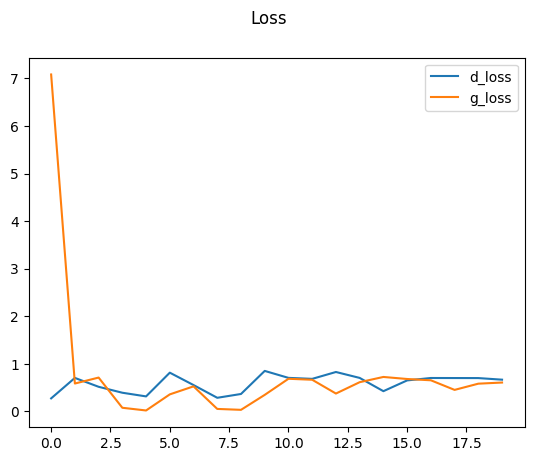

In [ ]:
plt.suptitle("Loss")
plt.plot(hist.history["d_loss"], label="d_loss")
plt.plot(hist.history["g_loss"], label="g_loss")
plt.legend()
plt.show()

Look at the output of our current model

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


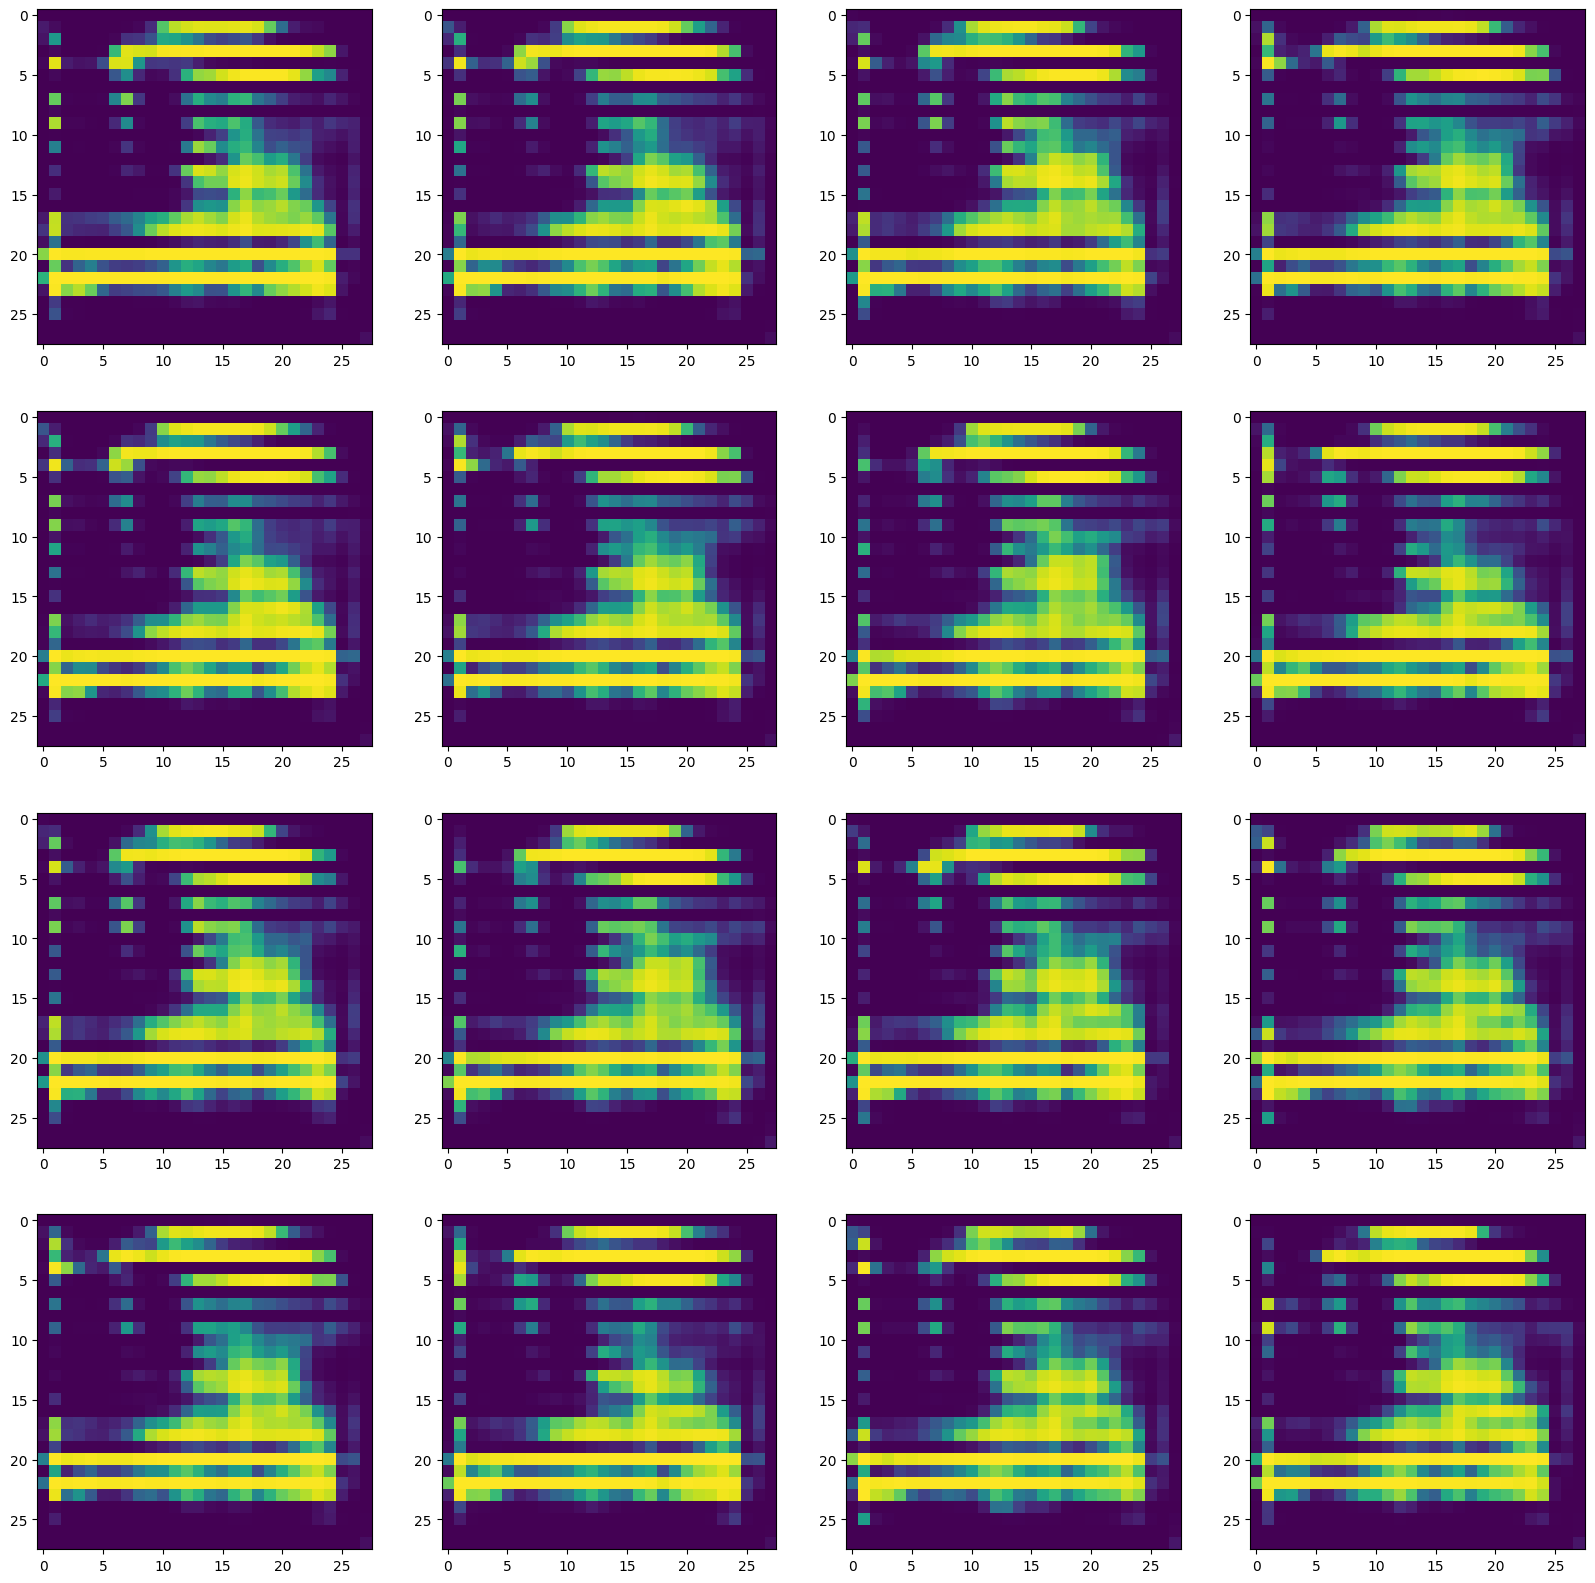

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1) * (c + 1) - 1])